In [ ]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [ ]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [3]:
# We recorded our own hands with a laptop webcam and used these images to train the model
# each class has around 500 images with 200 x 200 pixels
train_dir = "c:/users/kogle/Documents/AKT/data"

# Scale down images to 100, 100 to increase the batch size because OOM Errors are an issue
# used GPU: GTX 1050
IMG_HEIGHT, IMG_WIDTH = 100, 100
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset="training")


validation_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset="validation")

Found 1423 images belonging to 3 classes.
Found 355 images belonging to 3 classes.


In [4]:
print(train_data_gen.class_indices)

{'Paper': 0, 'Rock': 1, 'Scissor': 2}


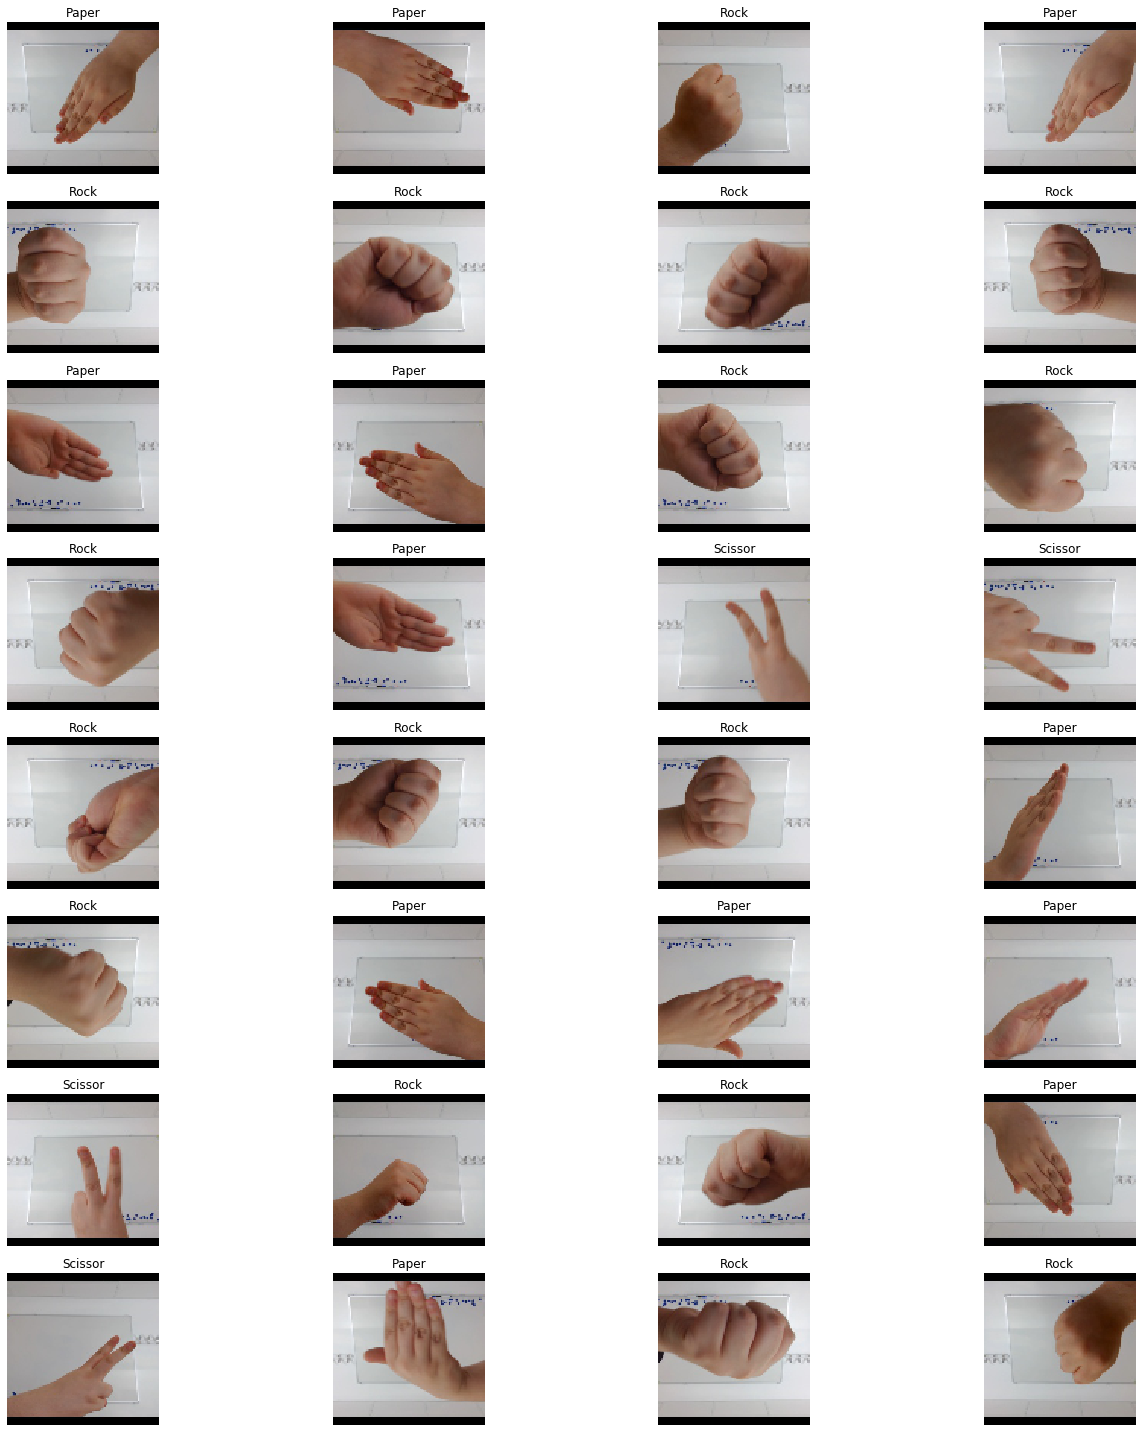

In [5]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

In [6]:

# This model achieved the best results 
# Because we have small images we didn't perform as many convolutions
# Originally we tested with a architecture that resembled the AlexNet Architecture but the results were horrendous
#       the loss did not decrease at all and the accuracy stagnated at around 40%

    
self_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    tf.keras.layers.Convolution2D(filters=48, kernel_size=(11,11), strides=(4,4)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    
    tf.keras.layers.Convolution2D(filters=128, kernel_size=(5,5), strides=(2, 2), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    
    
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(64, 'relu'),
    
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

self_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 48)        17472     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [7]:
# Trying a Feature Extractor in this case the InceptionV3 Feature Extractor

base_model = tf.keras.applications.inception_v3.InceptionV3(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

inception_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1000, 'relu'),
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 24,430,347
Trainable params: 24,395,915
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

In [9]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

In [10]:
self_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'accuracy'])

history = self_model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=50, 
    epochs=25,
    validation_data = skip_broken_images(validation_data_gen), 
    validation_steps = 50
)


Epoch 1/25
50/50 [==============================] - 9s 190ms/step - loss: 1.0312 - categorical_accuracy: 0.4681 - accuracy: 0.4681 - val_loss: 1.1767 - val_categorical_accuracy: 0.4562 - val_accuracy: 0.4562
Epoch 2/25
50/50 [==============================] - 7s 143ms/step - loss: 0.7279 - categorical_accuracy: 0.6336 - accuracy: 0.6336 - val_loss: 0.9352 - val_categorical_accuracy: 0.5108 - val_accuracy: 0.5108
Epoch 3/25
50/50 [==============================] - 7s 149ms/step - loss: 0.5263 - categorical_accuracy: 0.7682 - accuracy: 0.7682 - val_loss: 1.0869 - val_categorical_accuracy: 0.5539 - val_accuracy: 0.5539
Epoch 4/25
50/50 [==============================] - 7s 146ms/step - loss: 0.4314 - categorical_accuracy: 0.8111 - accuracy: 0.8111 - val_loss: 1.0865 - val_categorical_accuracy: 0.5674 - val_accuracy: 0.5674
Epoch 5/25
50/50 [==============================] - 7s 144ms/step - loss: 0.3533 - categorical_accuracy: 0.8433 - accuracy: 0.8433 - val_loss: 1.1646 - val_categorical_

In [11]:
'''
Trying out the Inception feature extractor
It is a more complex architecture than our own
and looking at the metrics for both
'''

inception_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'accuracy'])

inception_history = inception_model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=50, 
    epochs=10,
    validation_data = skip_broken_images(validation_data_gen), 
    validation_steps = 50
)

Epoch 1/10
50/50 [==============================] - 72s 1s/step - loss: 0.5700 - categorical_accuracy: 0.7997 - accuracy: 0.7997 - val_loss: 10.7655 - val_categorical_accuracy: 0.3255 - val_accuracy: 0.3255
Epoch 2/10
50/50 [==============================] - 33s 650ms/step - loss: 0.2004 - categorical_accuracy: 0.9457 - accuracy: 0.9457 - val_loss: 2.3189 - val_categorical_accuracy: 0.6395 - val_accuracy: 0.6395
Epoch 3/10
50/50 [==============================] - 39s 781ms/step - loss: 0.1707 - categorical_accuracy: 0.9482 - accuracy: 0.9482 - val_loss: 1.1251 - val_categorical_accuracy: 0.8133 - val_accuracy: 0.8133
Epoch 4/10
50/50 [==============================] - 31s 613ms/step - loss: 0.1151 - categorical_accuracy: 0.9621 - accuracy: 0.9621 - val_loss: 4.8124 - val_categorical_accuracy: 0.4933 - val_accuracy: 0.4933
Epoch 5/10
50/50 [==============================] - 45s 904ms/step - loss: 0.1039 - categorical_accuracy: 0.9709 - accuracy: 0.9709 - val_loss: 0.3727 - val_categoric

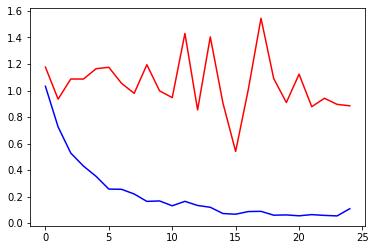

'\nthe \n'

In [13]:
plt.plot(history.history['loss'], 'b')
plt.plot( history.history['val_loss'], 'r')
plt.show()
'''
the loss function looks rather bad...
'''

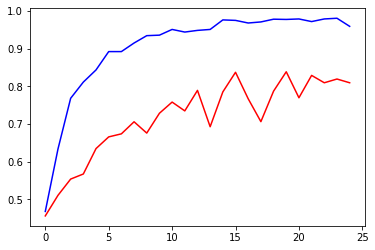

In [14]:
plt.plot(history.history['categorical_accuracy'], 'b')
plt.plot( history.history['val_categorical_accuracy'], 'r')
plt.show()
'''
However the plot for the accuracy shows actually really good values 
and the main problem seems to be that the model trains too fast for the
training data and the validation 
'''

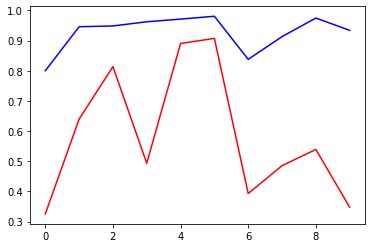

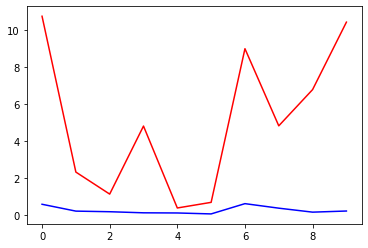

'\n\n'

In [15]:
plt.plot(inception_history.history['categorical_accuracy'], 'b')
plt.plot( inception_history.history['val_categorical_accuracy'], 'r')
plt.show()

plt.plot(inception_history.history['loss'], 'b')
plt.plot(inception_history.history['val_loss'], 'r')
plt.show()

'''
The incetion model seems completely unfit for this problem, due to the simple training data
the model is too complex to produce any significant outcomes
'''

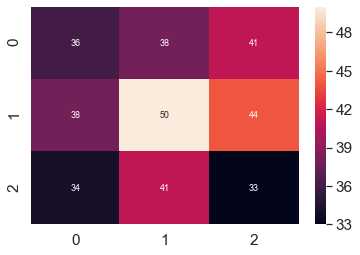

'\nThe confucsion matrix does not look that good, which surprised us because the accuracy is actually really okay\n'

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

Y_pred = self_model.predict_generator(validation_data_gen)
y_pred = np.argmax(Y_pred, axis=1)


array = confusion_matrix(validation_data_gen.classes, y_pred)
df_cm = pd.DataFrame(array, range(3),
                  range(3))


sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 9})
plt.show()

'''
The confucsion matrix does not look that good, which surprised us because the accuracy is actually really okay
'''

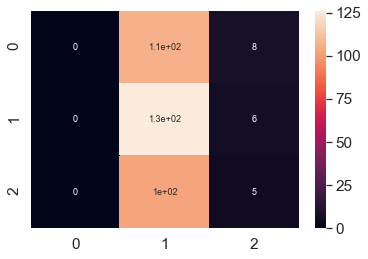

'\nwith this model the problem is that the class 2 is not recognised at all\neven though they use the data generator\n'

In [17]:
Y_pred = inception_model.predict_generator(validation_data_gen)
y_pred = np.argmax(Y_pred, axis=1)


array = confusion_matrix(validation_data_gen.classes, y_pred)
df_cm = pd.DataFrame(array, range(3),
                  range(3))


sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 9})
plt.show()

'''
Here you can see the problem with the inception model more clearly.
The Inception model defaults everything to class 2 or whatever class is favored in any given seed of compilation.
'''

In [18]:
self_model.save('self_model.h5')

In [19]:
# The following implementation is a little rock paper scissor game against our model
# The model will predict what the user chooses and picks accordingly

import cv2

rock_paper_scissor = {
    0: "Paper",
    1: "Rock",
    2: "Scissor"
}

file = './self_model.h5'
model = tf.keras.models.load_model(file)

def choose(pick):
    if pick == 0:
        return 2
    elif pick == 1:
        return 0
    elif pick == 2:
        return 1

def play(image, model):
    prediction = model.predict(image)
    print(prediction)
    max_class = np.argmax(prediction)
    computer_choice = choose(max_class)
    
    print("computer chose " + rock_paper_scissor[computer_choice])


In [ ]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

if ret:
    center_x = int(frame.shape[1] / 2)
    center_y = int(frame.shape[0] / 2)
    size = 200
    start_point = (center_x + size, center_y + size)
    end_point = (center_x - size, center_y - size)
    color = (255, 0, 0)
    thickness = 2

    rect = frame.copy()
    rect = cv2.rectangle(rect, start_point, end_point, color, thickness)
    
    # only take the middle of the frame 
    cropped = frame[center_y - size:center_y + size, center_x - size:center_x + size]
    # resize for model input
    resized = cv2.resize(cropped, (100, 100))
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    image_np_expanded = np.expand_dims(resized, axis=0)
    image_np_expanded = tf.cast(image_np_expanded, tf.float32)
    print(resized.shape)
    plt.imshow(resized)
    
    # Display the resulting frame
    play(image=image_np_expanded, model=model)


In [ ]:

frame = cv2.imread("./paper41.jpg")
# resize for model input
resized = cv2.resize(frame, (100,100))
resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
image_np_expanded = np.expand_dims(resized, axis=0)
image_np_expanded = tf.cast(image_np_expanded, tf.float32)
print(resized.shape)
plt.imshow(resized)
    
# Display the resulting frame
play(image=image_np_expanded, model=model)


In [ ]:
img = cv2.imread("korg_joke.png")
resized = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(resized)